In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder


# Load and Explore data

In [4]:
df = pd.read_csv("fake_job_postings.csv")

In [18]:
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
# Percentage  of null values in each column
null_percentage = (df.isnull().sum()/df.shape[0])*100

In [7]:
df['fraudulent'].value_counts(normalize = True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

In [8]:
# Analysing fraud rows
fraud = df[df['fraudulent'] == 1]

# EDA

## --- 1. Bar Chart of Real vs Fake Jobs ---

C:\Users\HP\AppData\Local\Temp\ipykernel_2488\2002276357.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="fraudulent", data=df, palette="Set2")


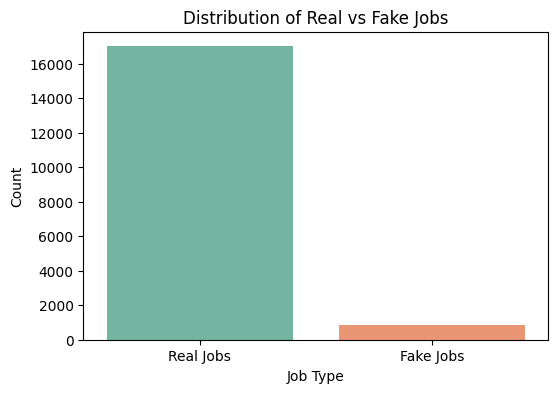

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x="fraudulent", data=df, palette="Set2")
plt.xticks([0,1], ["Real Jobs", "Fake Jobs"])
plt.title("Distribution of Real vs Fake Jobs")
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.show()

## --- 2. WordCloud for Descriptions ---

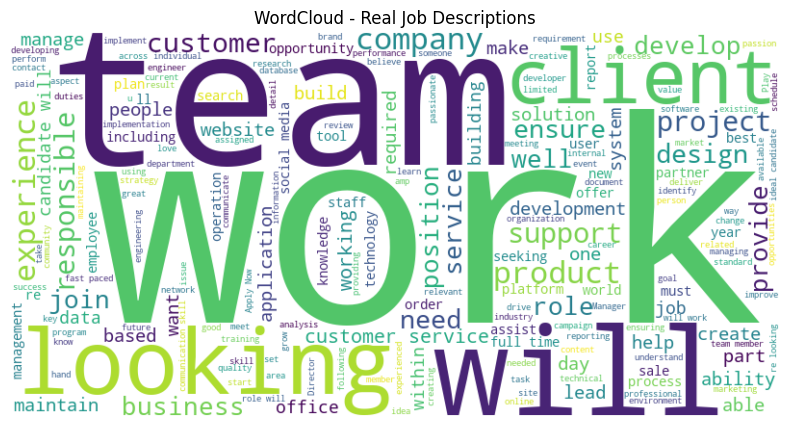

In [13]:
# Real jobs descriptions
real_text = " ".join(df[df['fraudulent']==0]['description'].dropna().astype(str))
real_wc = WordCloud(width=800, height=400, background_color="white", max_words=200).generate(real_text)

plt.figure(figsize=(10,5))
plt.imshow(real_wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Real Job Descriptions")
plt.show()

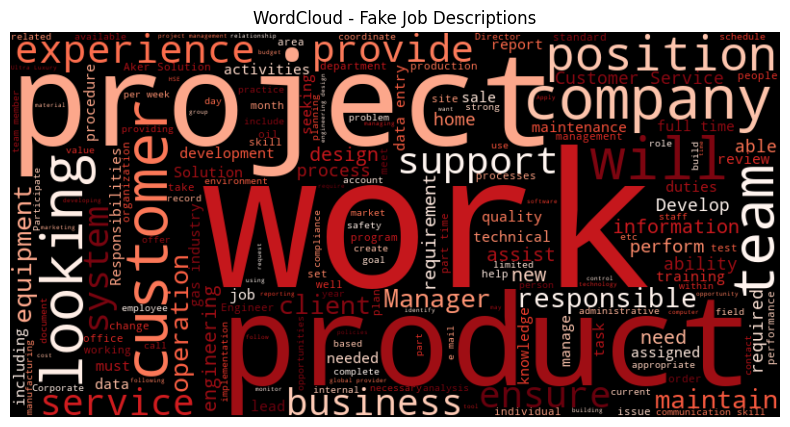

In [14]:
# Fake jobs descriptions
fake_text = " ".join(df[df['fraudulent']==1]['description'].dropna().astype(str))
fake_wc = WordCloud(width=800, height=400, background_color="black", colormap="Reds", max_words=200).generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(fake_wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Fake Job Descriptions")
plt.show()

## --- 3. Most Common Words in Fake Job Titles ---

C:\Users\HP\AppData\Local\Temp\ipykernel_2488\1946152754.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=common_words_df, palette="Reds_r")


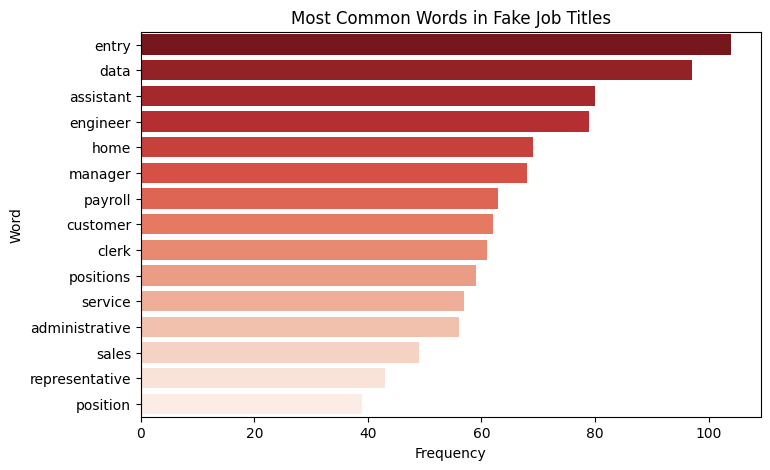

In [17]:
fake_titles = df[df['fraudulent']==1]['title'].dropna().astype(str)
# simple tokenization
words = []
for title in fake_titles:
    title = re.sub(r'[^a-zA-Z ]', '', title)  # remove punctuation/numbers
    words.extend(title.lower().split())

# Count top words
word_counts = Counter(words).most_common(15)
common_words_df = pd.DataFrame(word_counts, columns=["Word", "Frequency"])

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Frequency", y="Word", data=common_words_df, palette="Reds_r")
plt.title("Most Common Words in Fake Job Titles")
plt.show()

# Data Cleaning

In [20]:
# download stopwords 
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### --- 1. Fill NaN values with empty string for text columns ---

In [21]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_cols:
    df[col] = df[col].fillna("")

### --- 2. Drop irrelevant columns ---

In [24]:
# Total columns in data
columns = df.columns

In [25]:
# Keep only meaningful features
df = df.drop(columns=['job_id'])

### --- 3. Remove duplicates ---

In [27]:
df = df.drop_duplicates()

### --- 4. Normalize text ---

In [31]:
def clean_text(text):
    text = text.lower()                                  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove links
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)                      # remove numbers
    tokens = text.split()                                # tokenize
    tokens = [w for w in tokens if w not in stop_words]  # remove stopwords
    return " ".join(tokens)

# Apply cleaning to text columns
for col in text_cols:
    df[col] = df[col].apply(clean_text)

# --- Check cleaned dataset ---
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,marketing intern,"US, NY, New York",Marketing,NaN,food weve created groundbreaking awardwinning ...,food fastgrowing james beard awardwinning onli...,experience content management systems major pl...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,customer service cloud video production,"NZ, , Auckland",Success,NaN,seconds worlds cloud video production service ...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part seconds team gainexperience...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,commissioning machinery assistant cma,"US, IA, Wever",NaN,NaN,valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,account executive washington dc,"US, DC, Washington",Sales,NaN,passion improving quality life geography heart...,company esri – environmental systems research ...,education bachelor’s master’s gis business adm...,culture anything corporate—we collaborative cr...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,bill review manager,"US, FL, Fort Worth",NaN,NaN,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefits offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Feature Engineering Pipeline

### --- 1. Merge multiple text fields ---

In [34]:
df["text"] = (
    df["title"] + " " +
    df["company_profile"] + " " +
    df["description"] + " " +
    df["requirements"] + " " +
)

### --- 2. Vectorizers ---

In [35]:
# Bag of Words
count_vectorizer = CountVectorizer(max_features=5000)  # limit to top 5000 words
X_bow = count_vectorizer.fit_transform(df["text"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigrams + bigrams
X_tfidf = tfidf_vectorizer.fit_transform(df["text"])

### --- 3. Handle categorical features ---

In [40]:
print(df["employment_type"].value_counts())
print(" ------------------ ")
print(df["required_experience"].value_counts())
print(" ------------------ ")
print(df["required_education"].value_counts())

employment_type
Full-time    11423
Contract      1514
Part-time      772
Temporary      237
Other          225
Name: count, dtype: int64
 ------------------ 
required_experience
Mid-Senior level    3768
Entry level         2637
Associate           2267
Not Applicable      1070
Director             383
Internship           372
Executive            140
Name: count, dtype: int64
 ------------------ 
required_education
Bachelor's Degree                    5099
High School or equivalent            1989
Unspecified                          1369
Master's Degree                       416
Associate Degree                      264
Certification                         165
Some College Coursework Completed     100
Professional                           73
Vocational                             47
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64


In [46]:
categorical_cols = ["employment_type", "required_experience", "required_education"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = encoder.fit_transform(df[categorical_cols].fillna(""))

### --- 4. Custom Features ---

In [50]:
# Description length
df["desc_length"] = df["description"].apply(lambda x: len(x.split()))

In [53]:
# Presence of suspicious keywords
suspicious_keywords = ["earn", "money", "income", "from home", "investment", "bonus", "credit card","quick money", "guaranteed income", "easy cash"]
df["suspicious_words"] = df["text"].apply(
    lambda x: sum(1 for word in suspicious_keywords if word in x.lower())
)

In [54]:
# Number of exclamation marks
df["exclaim_count"] = df["text"].apply(lambda x: x.count("!"))

### --- 5. Combine all features ---

In [58]:
from scipy.sparse import hstack

X_final = hstack([
    X_tfidf,   # text features (high-dimensional)
    X_cat,     # categorical features (one-hot encoded)
    np.array(df[["desc_length", "suspicious_words", "exclaim_count"]])
])

y = df["fraudulent"]

# Train/Test Split for Generalization

In [60]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    stratify=y,      #  keeps class ratio same (important for imbalanced data)
    random_state=42  # reproducibility
)

In [61]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Fraud ratio in train:", sum(y_train)/len(y_train))
print("Fraud ratio in test:", sum(y_test)/len(y_test))

Training set shape: (14079, 5031)
Testing set shape: (3520, 5031)
Fraud ratio in train: 0.0486540237232758
Fraud ratio in test: 0.04857954545454545


# Model Training

###  ---Logistic Regression---

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model_lr = LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)


###  ---XGBoost Classifier---

In [75]:
import xgboost as xgb
# Calculate scale_pos_weight to handle imbalance
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:02:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Model Evaluation

### ---Logistic Regression---

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3349
           1       0.57      0.85      0.69       171

    accuracy                           0.96      3520
   macro avg       0.78      0.91      0.83      3520
weighted avg       0.97      0.96      0.97      3520



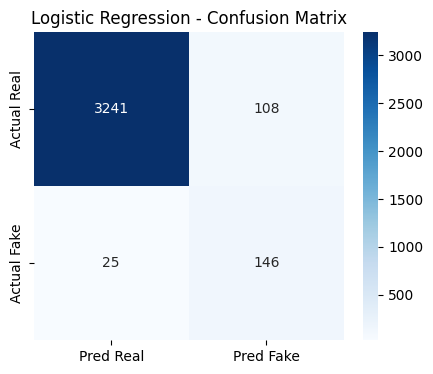

In [74]:
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Real","Pred Fake"],
            yticklabels=["Actual Real","Actual Fake"])
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

### ---XGBoost Classifier

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3349
           1       0.83      0.73      0.78       171

    accuracy                           0.98      3520
   macro avg       0.91      0.86      0.88      3520
weighted avg       0.98      0.98      0.98      3520



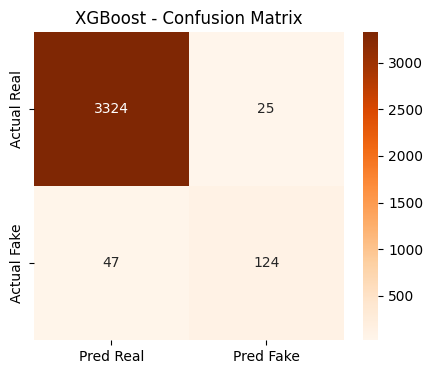

In [76]:
print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Pred Real","Pred Fake"],
            yticklabels=["Actual Real","Actual Fake"])
plt.title("XGBoost - Confusion Matrix")
plt.show()

### ---Comparing LR vs XGBoost---

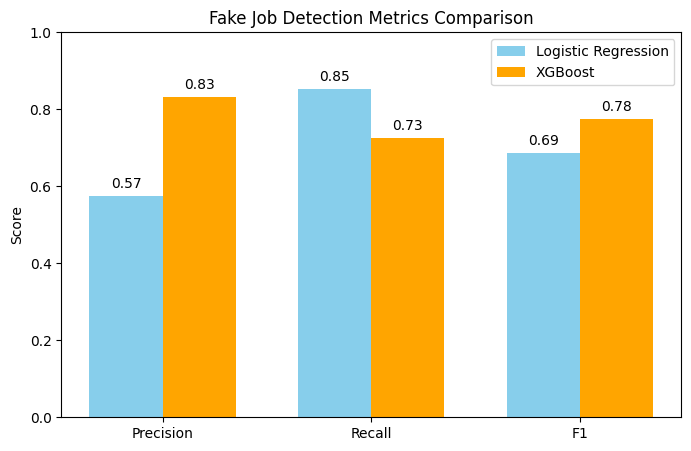

In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Calculate metrics for fake jobs (class=1) ---
metrics = {}

metrics['Logistic Regression'] = {
    'Precision': precision_score(y_test, y_pred_lr, pos_label=1),
    'Recall': recall_score(y_test, y_pred_lr, pos_label=1),
    'F1': f1_score(y_test, y_pred_lr, pos_label=1)
}

metrics['XGBoost'] = {
    'Precision': precision_score(y_test, y_pred_xgb, pos_label=1),
    'Recall': recall_score(y_test, y_pred_xgb, pos_label=1),
    'F1': f1_score(y_test, y_pred_xgb, pos_label=1)
}

# --- Plotting ---
labels = ['Precision', 'Recall', 'F1']
x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8,5))
lr_vals = [metrics['Logistic Regression'][m] for m in labels]
xgb_vals = [metrics['XGBoost'][m] for m in labels]

ax.bar(x - width/2, lr_vals, width, label='Logistic Regression', color='skyblue')
ax.bar(x + width/2, xgb_vals, width, label='XGBoost', color='orange')

ax.set_ylabel('Score')
ax.set_title('Fake Job Detection Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)
ax.legend()

# Display values on top of bars
for i in range(len(labels)):
    ax.text(i - width/2, lr_vals[i]+0.02, f"{lr_vals[i]:.2f}", ha='center', fontsize=10)
    ax.text(i + width/2, xgb_vals[i]+0.02, f"{xgb_vals[i]:.2f}", ha='center', fontsize=10)

plt.show()


# Saving the Model

In [85]:
import joblib

# Save Logistic Regression
joblib.dump(model, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']

In [86]:
# Save XGBoost
joblib.dump(xgb_model, "xgboost_model.pkl")

['xgboost_model.pkl']

In [88]:
# Save TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

# User Input

### ---Load Models & Vectorizer---

In [89]:
# Load trained models
loaded_lr = joblib.load("logistic_regression_model.pkl")
loaded_xgb = joblib.load("xgboost_model.pkl")

# Load TF-IDF vectorizer
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

### ---Prediction Function---

In [101]:
from scipy.sparse import hstack, csr_matrix

# Example suspicious keywords
suspicious_keywords = ["earn", "money", "income", "from home", "investment", "bonus", "credit card"]

# --- Text cleaning function ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove links
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

# --- Prediction function ---
def predict_job_posting(
    title,
    company_profile="",
    description="",
    requirements="",
    model="xgb",
    vectorizer=None,
    lr_model=None,
    xgb_model=None,
    n_categorical_features=0  # number of categorical features used during training
):
    # --- Validation ---
    if vectorizer is None:
        raise ValueError("TF-IDF vectorizer must be provided")
    if model.lower() == "lr" and lr_model is None:
        raise ValueError("Logistic Regression model must be provided")
    if model.lower() == "xgb" and xgb_model is None:
        raise ValueError("XGBoost model must be provided")

    # --- Merge and clean text ---
    text = f"{title} {company_profile} {description} {requirements}"
    text_clean = clean_text(text)

    # --- TF-IDF features ---
    X_text = vectorizer.transform([text_clean])

    # --- Custom numeric features ---
    desc_length = len(text.split())
    suspicious_words = sum(1 for word in suspicious_keywords if word in text.lower())
    exclaim_count = text.count("!")
    X_custom = np.array([[desc_length, suspicious_words, exclaim_count]])

    # --- Dummy categorical features to match training ---
    if n_categorical_features > 0:
        X_cat_dummy = csr_matrix(np.zeros((1, n_categorical_features)))
        X_input = hstack([X_text, X_custom, X_cat_dummy])
    else:
        X_input = hstack([X_text, X_custom])

    # --- Prediction ---
    if model.lower() == "lr":
        pred = lr_model.predict(X_input)[0]
    else:
        pred = xgb_model.predict(X_input)[0]

    return "Fake Job" if pred == 1 else "Real Job"


### ---Example Usage---

In [104]:
result = predict_job_posting(
    title="Work from Home and Earn Money Fast",
    company_profile="ABC Pvt Ltd",
    description="This is an amazing opportunity to earn from home with flexible hours.",
    requirements="No experience needed",
    model="xgb",
    vectorizer=loaded_vectorizer,
    xgb_model=loaded_xgb,
    n_categorical_features=28  # number of categorical features used during training
)

print("Prediction 1:", result)


Prediction 1: Fake Job


In [106]:
result = predict_job_posting(
    title="Software Engineer",
    company_profile="Tech Solutions Inc.",
    description="We are looking for a Software Engineer with 2+ years experience in Python and ML frameworks.",
    requirements="Bachelor's degree in Computer Science or related field.",
    model="xgb",
    vectorizer=loaded_vectorizer,
    xgb_model=loaded_xgb,
    n_categorical_features=28
)
print("Prediction 2:", result)  


Prediction 2: Real Job
